In [2]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
from pyspark.sql.functions import udf
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, mean, stddev,stddev_pop,avg,max,to_timestamp
from pyspark.sql import Window
spark = SparkSession.builder.appName('eda elevator').getOrCreate()
assert spark.version >= '2.4' # make sure we have Spark 2.4+
spark.sparkContext.setLogLevel('WARN')
sc = spark.sparkContext

In [3]:
 data_schema = types.StructType([
    types.StructField('Timestamp', types.StringType()),
    types.StructField('AccelerationX', types.DoubleType()),
    types.StructField('AccelerationY', types.DoubleType()),
    types.StructField('AccelerationZ', types.DoubleType())
    ])

In [4]:
df = spark.read.csv("/home/riat/sfuhome/EDS_9.csv/EDS_9.csv",schema=data_schema)

In [5]:
df_filter = df.where((df['Timestamp']>='2018-07-09 12:00:00') & (df['Timestamp']<='2018-08-09 12:00:00'))

In [6]:
df_filter = df_filter.select(df_filter['Timestamp'],(-1 * df_filter['AccelerationZ']).alias("AccelerationZ"))
#df_filter = df_filter.withColumnRenamed("- AccelerationZ", "AccelerationZ")

In [7]:
# Apply Z- Normalization 

unlist = udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["AccelerationZ"],
    outputCol="Zvector")
tempdata = assembler.transform(df_filter)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()

In [8]:
# Strip the timestamp to seconds
scaledData = scaledData.withColumn("Timestamp1", to_timestamp("Timestamp", 'yyyy-MM-dd HH:mm:ss')).cache()


In [9]:
movAvg = scaledData.withColumn("movingAverage", functions.avg(scaledData["Zscale"])
             .over(Window.partitionBy(scaledData["timestamp1"]).rowsBetween(-1,1))).cache()

In [10]:
find_mode = scaledData.withColumn("Frequency", functions.round(scaledData["Zscale"], 1))
find_mode.show()

+--------------------+-------------+---------+-------------------+---------+
|           Timestamp|AccelerationZ|   Zscale|         Timestamp1|Frequency|
+--------------------+-------------+---------+-------------------+---------+
|2018-07-09 12:00:...|     1.117188| 2.434588|2018-07-09 12:00:00|      2.4|
|2018-07-09 12:00:...|     1.105469|-0.572898|2018-07-09 12:00:00|     -0.6|
|2018-07-09 12:00:...|     1.101563|-1.575308|2018-07-09 12:00:00|     -1.6|
|2018-07-09 12:00:...|     1.121094| 3.436998|2018-07-09 12:00:00|      3.4|
|2018-07-09 12:00:...|     1.105469|-0.572898|2018-07-09 12:00:00|     -0.6|
|2018-07-09 12:00:...|     1.113281| 1.431922|2018-07-09 12:00:00|      1.4|
|2018-07-09 12:00:...|     1.101563|-1.575308|2018-07-09 12:00:00|     -1.6|
|2018-07-09 12:00:...|     1.105469|-0.572898|2018-07-09 12:00:00|     -0.6|
|2018-07-09 12:00:...|     1.109375| 0.429512|2018-07-09 12:00:00|      0.4|
|2018-07-09 12:00:...|     1.101563|-1.575308|2018-07-09 12:00:00|     -1.6|

In [9]:
count_zscale = find_mode.groupby(find_mode['Frequency']).count()

In [10]:
count_zscale.toPandas().to_csv('/home/riat/sfuhome/EDA9_frequency.csv')

In [40]:
find_sample = find_mode.where(find_mode['Frequency']==92.7)
#| (functions.round(scaledData["Zscale"], 1)==-37.7)) 
find_sample.show()

+--------------------+-------------+---------+-------------------+---------+
|           Timestamp|AccelerationZ|   Zscale|         Timestamp1|Frequency|
+--------------------+-------------+---------+-------------------+---------+
|2018-08-07 18:32:...|      1.46875|92.657129|2018-08-07 18:32:31|     92.7|
+--------------------+-------------+---------+-------------------+---------+



In [97]:
df_sample = scaledData.where((scaledData['Timestamp']>='2018-07-17 15:19:00') & (scaledData['Timestamp']<='2018-07-17 15:19:47'))

In [8]:
scaledData.show()

+--------------------+-------------+---------+-------------------+
|           Timestamp|AccelerationZ|   Zscale|         Timestamp1|
+--------------------+-------------+---------+-------------------+
|2018-07-09 12:00:...|     1.117188| 2.467246|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.105469|-0.558086|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.101563|-1.566444|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.121094| 3.475604|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.105469|-0.558086|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.113281|  1.45863|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.101563|-1.566444|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.105469|-0.558086|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.109375| 0.450272|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.101563|-1.566444|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.109375| 0.450272|2018-07-09 12:00:00|
|2018-07-09 12:00:...|     1.097656| -2.57506|2018-07-09 12:00

In [11]:
# RawData anomaly detection 
df_sort = scaledData.sort(col("Zscale").desc())
df_sort.show()

+--------------------+-------------+---------+-------------------+
|           Timestamp|AccelerationZ|   Zscale|         Timestamp1|
+--------------------+-------------+---------+-------------------+
|2018-07-12 10:25:...|     1.460938| 91.20843|2018-07-12 10:25:57|
|2018-07-09 12:00:...|     1.332031|57.930292|2018-07-09 12:00:22|
|2018-07-11 11:50:...|     1.324219|55.913576|2018-07-11 11:50:12|
|2018-07-13 21:04:...|     1.320313|54.905218|2018-07-13 21:04:13|
|2018-07-09 12:00:...|     1.316406|53.896602|2018-07-09 12:00:22|
|2018-07-10 15:00:...|     1.316406|53.896602|2018-07-10 15:00:34|
|2018-07-12 15:15:...|     1.300781|49.862912|2018-07-12 15:15:18|
|2018-07-13 18:19:...|     1.296875|48.854554|2018-07-13 18:19:55|
|2018-07-12 09:49:...|     1.292969|47.846196|2018-07-12 09:49:00|
|2018-07-12 09:47:...|     1.285156|45.829222|2018-07-12 09:47:22|
|2018-07-09 12:00:...|      1.28125|44.820864|2018-07-09 12:00:47|
|2018-07-12 18:15:...|     1.265625|40.787174|2018-07-12 18:15

In [12]:
df_sort = scaledData.sort(col("Zscale"))
df_sort.show()

+--------------------+-------------+----------+-------------------+
|           Timestamp|AccelerationZ|    Zscale|         Timestamp1|
+--------------------+-------------+----------+-------------------+
|2018-07-09 12:01:...|     0.878906|-59.046722|2018-07-09 12:01:07|
|2018-07-13 18:32:...|     0.882813|-58.038106|2018-07-13 18:32:55|
|2018-07-11 08:33:...|     0.890625| -56.02139|2018-07-11 08:33:47|
|2018-07-12 18:51:...|     0.894531|-55.013032|2018-07-12 18:51:12|
|2018-07-11 16:33:...|     0.902344|-52.996058|2018-07-11 16:33:19|
|2018-07-13 18:30:...|      0.90625|  -51.9877|2018-07-13 18:30:39|
|2018-07-13 21:04:...|     0.910156|-50.979342|2018-07-13 21:04:13|
|2018-07-12 10:03:...|     0.914063|-49.970725|2018-07-12 10:03:29|
|2018-07-09 17:42:...|     0.925781|-46.945651|2018-07-09 17:42:58|
|2018-07-13 17:33:...|     0.933594|-44.928677|2018-07-13 17:33:59|
|2018-07-13 21:04:...|     0.933594|-44.928677|2018-07-13 21:04:13|
|2018-07-11 16:34:...|     0.941406|-42.911961|2

In [13]:
# RawData anomaly detection 

df_sort_mov = movAvg.sort(col("movingAverage").desc())
df_sort_mov.show()

+--------------------+-------------+----------+-------------------+------------------+
|           Timestamp|AccelerationZ|    Zscale|         Timestamp1|     movingAverage|
+--------------------+-------------+----------+-------------------+------------------+
|2018-07-12 10:25:...|     1.105469| -0.558086|2018-07-12 10:25:57| 35.74512566666667|
|2018-07-13 18:19:...|     1.296875| 48.854554|2018-07-13 18:19:55|        33.2239725|
|2018-07-12 09:49:...|     1.292969| 47.846196|2018-07-12 09:49:00|        32.7197935|
|2018-07-12 15:19:...|     1.222656| 29.694461|2018-07-12 15:19:03|28.686103000000003|
|2018-07-12 18:51:...|     1.210938| 26.669387|2018-07-12 18:51:13|28.181924000000002|
|2018-07-10 17:36:...|      1.21875| 28.686103|2018-07-10 17:36:58|         27.677745|
|2018-07-11 16:34:...|     1.226563| 30.703077|2018-07-11 16:34:08|         27.173566|
|2018-07-13 21:04:...|     1.179688| 18.602007|2018-07-13 21:04:13|26.669387333333333|
|2018-07-12 10:25:...|       1.0625|-11.650

In [14]:
# RawData anomaly detection 

df_sort_mov = movAvg.sort(col("movingAverage"))
df_sort_mov.show()

+--------------------+-------------+----------+-------------------+-------------------+
|           Timestamp|AccelerationZ|    Zscale|         Timestamp1|      movingAverage|
+--------------------+-------------+----------+-------------------+-------------------+
|2018-07-10 15:01:...|     0.980469|-32.827607|2018-07-10 15:01:19|         -28.793917|
|2018-07-12 18:51:...|     0.894531|-55.013032|2018-07-12 18:51:12|          -27.11332|
|2018-07-13 18:33:...|     0.992188|-29.802275|2018-07-13 18:33:08|-26.272893000000003|
|2018-07-11 08:33:...|     1.121094|  3.475604|2018-07-11 08:33:47|         -26.272893|
|2018-07-13 16:31:...|     0.964844|-36.861297|2018-07-13 16:31:05|        -26.2728925|
|2018-07-13 18:30:...|      0.90625|  -51.9877|2018-07-13 18:30:39| -26.10479033333333|
|2018-07-09 12:01:...|       1.0625|-11.650798|2018-07-09 12:01:07|-25.432551333333333|
|2018-07-09 12:01:...|     0.878906|-59.046722|2018-07-09 12:01:07|-25.432551333333333|
|2018-07-12 18:51:...|       1.0

### Anomaly 1 

In [9]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-30 14:54:15' and '2018-07-30 14:54:55' ''')

CPU times: user 217 ms, sys: 9.28 ms, total: 226 ms
Wall time: 5min 8s


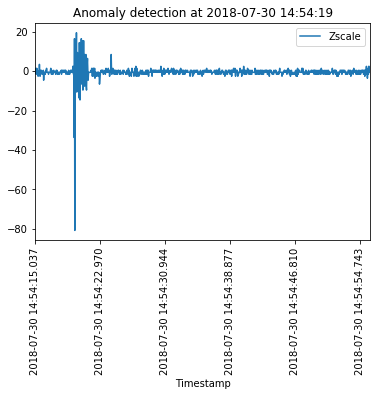

In [10]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%matplotlib inline
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-30 14:54:19')
plt.rcParams["figure.figsize"] = [10, 5]

In [11]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-30 14:54:15' and '2018-07-30 14:54:55' ''')

CPU times: user 109 ms, sys: 8.8 ms, total: 118 ms
Wall time: 1min


Text(0.5, 1.0, 'Anomaly detection at 2018-07-12 10:25:57')

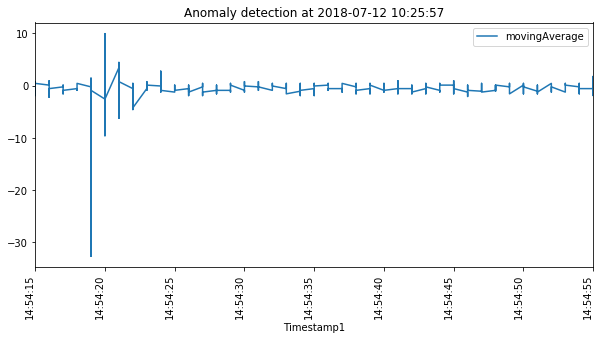

In [12]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-12 10:25:57')

### Anomaly 2

In [15]:
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-12 10:25:50' and '2018-07-12 10:26:10' ''')

CPU times: user 47.3 ms, sys: 3.89 ms, total: 51.2 ms
Wall time: 26.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-09 17:42:58')

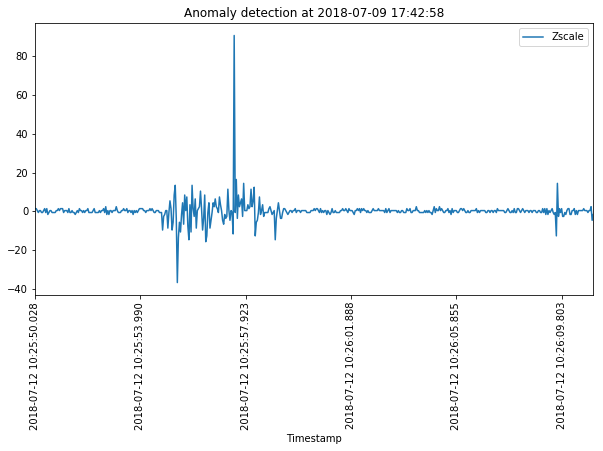

In [16]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 17:42:58')

In [17]:
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-12 10:25:50' and '2018-07-12 10:26:10' ''')

CPU times: user 67.1 ms, sys: 268 µs, total: 67.4 ms
Wall time: 26.4 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-09 17:42:58')

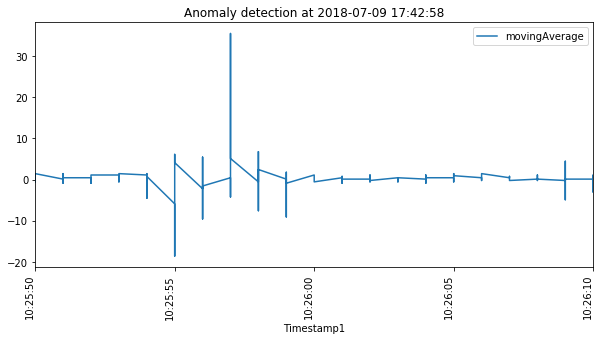

In [18]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 17:42:58')

### Anomaly 3

In [14]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-16 18:03:30' and '2018-07-16 18:04:30' ''')

CPU times: user 254 ms, sys: 9.2 ms, total: 264 ms
Wall time: 26.1 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-16 18:03:42')

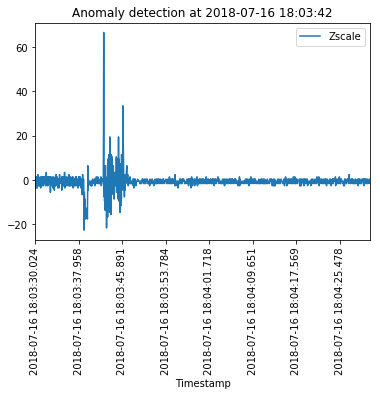

In [15]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-16 18:03:42')

In [17]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-16 18:03:30' and '2018-07-16 18:04:30' ''')

CPU times: user 133 ms, sys: 12.4 ms, total: 145 ms
Wall time: 1min


Text(0.5, 1.0, 'Anomaly detection at 2018-07-12 10:25:57')

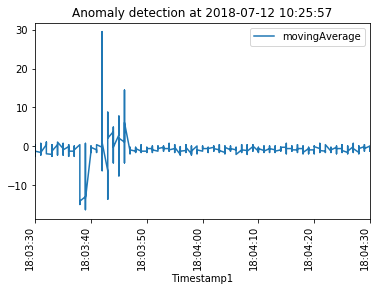

In [18]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-16 18:03:42')

### Anomaly 4 

In [20]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-08-07 08:00:10' and '2018-08-07 08:00:55' ''')

CPU times: user 87.6 ms, sys: 6.78 ms, total: 94.4 ms
Wall time: 16.8 s


Text(0.5, 1.0, 'Anomaly detection at 2018-08-07 08:00:18')

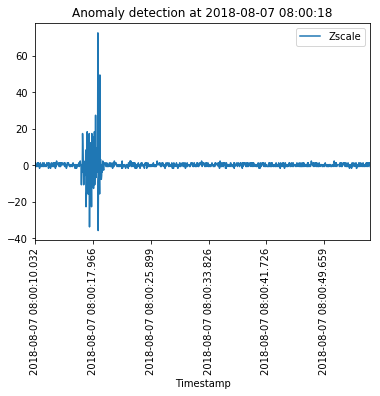

In [21]:
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-08-07 08:00:18')

In [23]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-08-07 08:00:10' and '2018-08-07 08:00:55' ''')


CPU times: user 102 ms, sys: 8.65 ms, total: 111 ms
Wall time: 16.9 s


Text(0.5, 1.0, 'Anomaly detection at 2018-08-07 08:00:18')

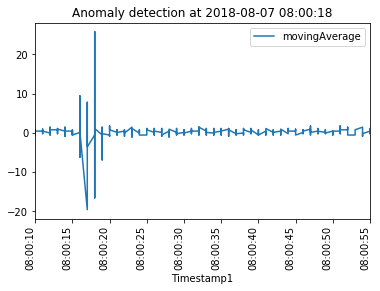

In [24]:
# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-08-07 08:00:18')

### Anomaly 5

CPU times: user 72.3 ms, sys: 3.95 ms, total: 76.2 ms
Wall time: 21.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-23 17:51:39')

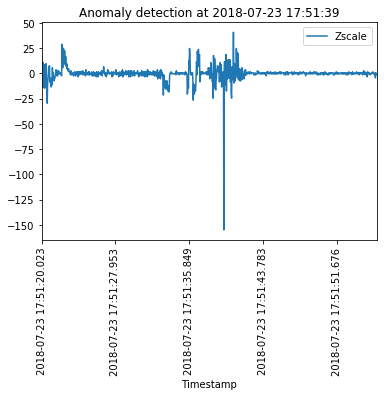

In [26]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-23 17:51:20' and '2018-07-23 17:51:55' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-23 17:51:39')




CPU times: user 86.4 ms, sys: 4.63 ms, total: 91.1 ms
Wall time: 22.2 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-23 17:51:39')

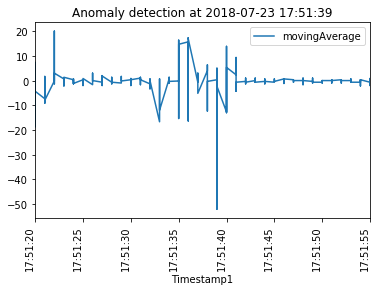

In [27]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-23 17:51:20' and '2018-07-23 17:51:55' ''')

# Convert to Pandas and plot

%time temp_pandas1 = df_check_mov.select("*").toPandas()
temp_pandas1.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-23 17:51:39')

From dates 2018-07-16 12:00:00 to 2018-07-24 12:00:00

### Anomaly 6

CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 23.3 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-26 17:42:45')

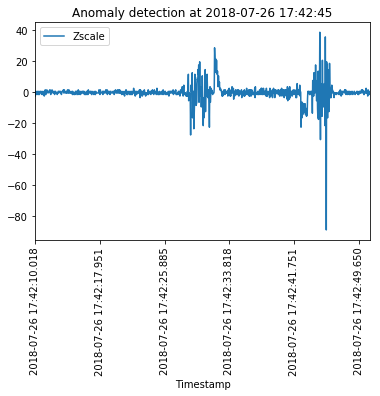

In [29]:

scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-26 17:42:10' and '2018-07-26 17:42:50' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-26 17:42:45')

CPU times: user 95.1 ms, sys: 8.69 ms, total: 104 ms
Wall time: 23.9 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-26 17:42:45')

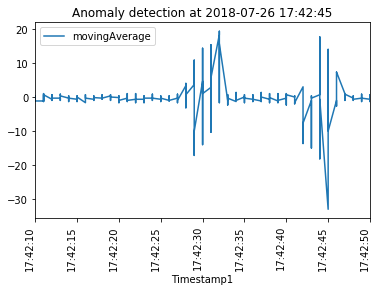

In [30]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-26 17:42:10' and '2018-07-26 17:42:50' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-26 17:42:45')

### Anomaly 7

CPU times: user 101 ms, sys: 7.67 ms, total: 109 ms
Wall time: 19.6 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-30 15:02:36')

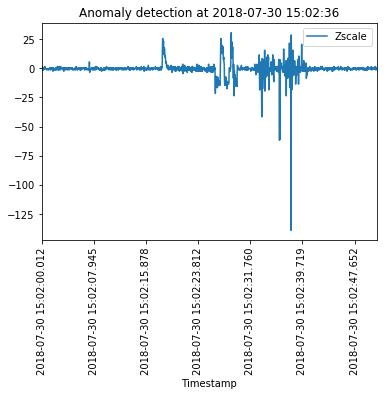

In [32]:

scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-30 15:02:00' and '2018-07-30 15:02:50' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-30 15:02:36')

CPU times: user 125 ms, sys: 4.04 ms, total: 129 ms
Wall time: 20.8 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-30 15:02:36')

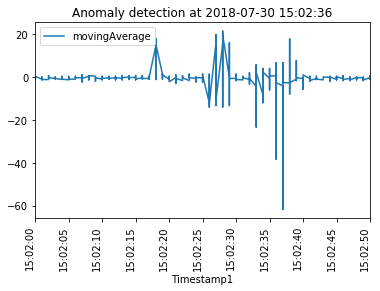

In [33]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-30 15:02:00' and '2018-07-30 15:02:50' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-30 15:02:36')

### Anomaly 8

CPU times: user 144 ms, sys: 3.89 ms, total: 148 ms
Wall time: 26.9 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-09 12:00:22')

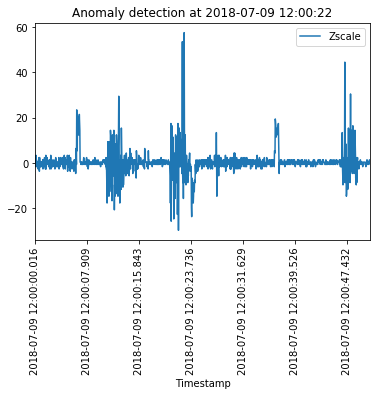

In [35]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-09 12:00:00' and '2018-07-09 12:00:50' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 12:00:22')

CPU times: user 129 ms, sys: 7.71 ms, total: 137 ms
Wall time: 27.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-09 12:00:22')

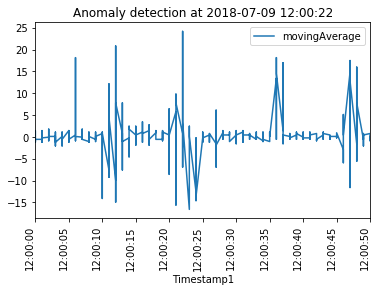

In [36]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-09 12:00:00' and '2018-07-09 12:00:50' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-09 12:00:22')

### Anomaly 9 

CPU times: user 106 ms, sys: 9 µs, total: 106 ms
Wall time: 18.8 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-30 15:02:37')

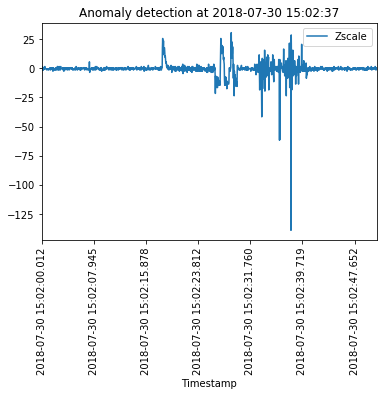

In [38]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-30 15:02:00' and '2018-07-30 15:02:50' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-30 15:02:37')

CPU times: user 112 ms, sys: 11.9 ms, total: 124 ms
Wall time: 19.8 s


Text(0.5, 1.0, 'Anomaly detection at 2018-07-30 15:02:37')

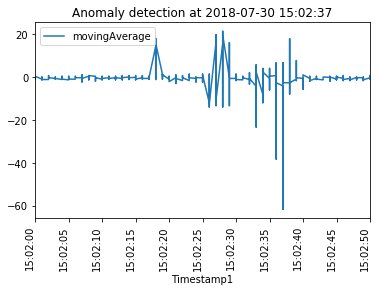

In [39]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-07-30 15:02:00' and '2018-07-30 15:02:50' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-07-30 15:02:37')

### Anomaly 10

CPU times: user 110 ms, sys: 84 µs, total: 110 ms
Wall time: 17.9 s


Text(0.5, 1.0, 'Anomaly detection at 2018-08-07 18:32:31')

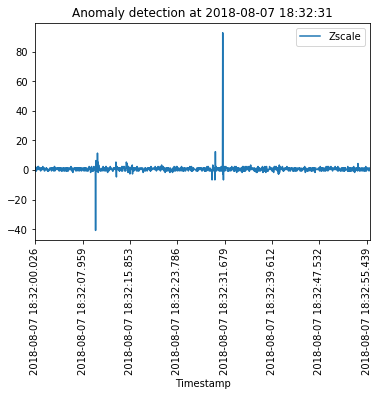

In [41]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-08-07 18:32:00' and '2018-08-07 18:32:55' ''')
# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-08-07 18:32:31')

CPU times: user 124 ms, sys: 494 µs, total: 124 ms
Wall time: 16.7 s


Text(0.5, 1.0, 'Anomaly detection at 2018-08-07 18:32:31')

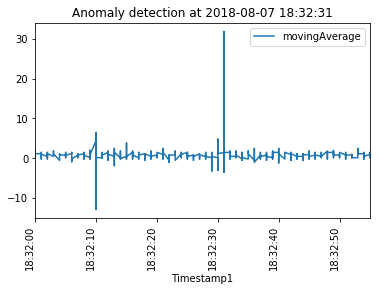

In [42]:
movAvg.createOrReplaceTempView("movAvg")
df_check_mov = spark.sql('''select Timestamp, Timestamp1, movingAverage from movAvg where Timestamp1 between '2018-08-07 18:32:00' and '2018-08-07 18:32:55' ''')

# Convert to Pandas and plot

%time temp_pandas2 = df_check_mov.select("*").toPandas()
temp_pandas2.plot(x ='Timestamp1', y='movingAverage', kind = 'line',rot=90)
plt.title('Anomaly detection at 2018-08-07 18:32:31')

### Normal peaks

CPU times: user 31.6 ms, sys: 3.99 ms, total: 35.6 ms
Wall time: 25.6 s


Text(0.5, 1.0, 'Normal peaks')

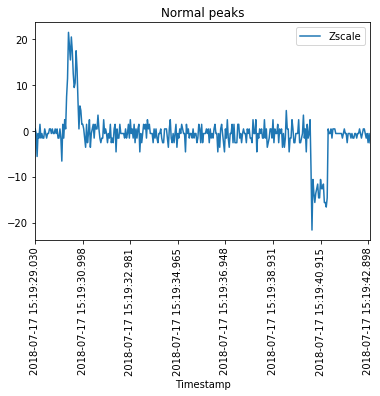

In [46]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-17 15:19:29' and '2018-07-17 15:19:42' ''')

# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Normal peaks')

CPU times: user 18.6 ms, sys: 0 ns, total: 18.6 ms
Wall time: 24.8 s


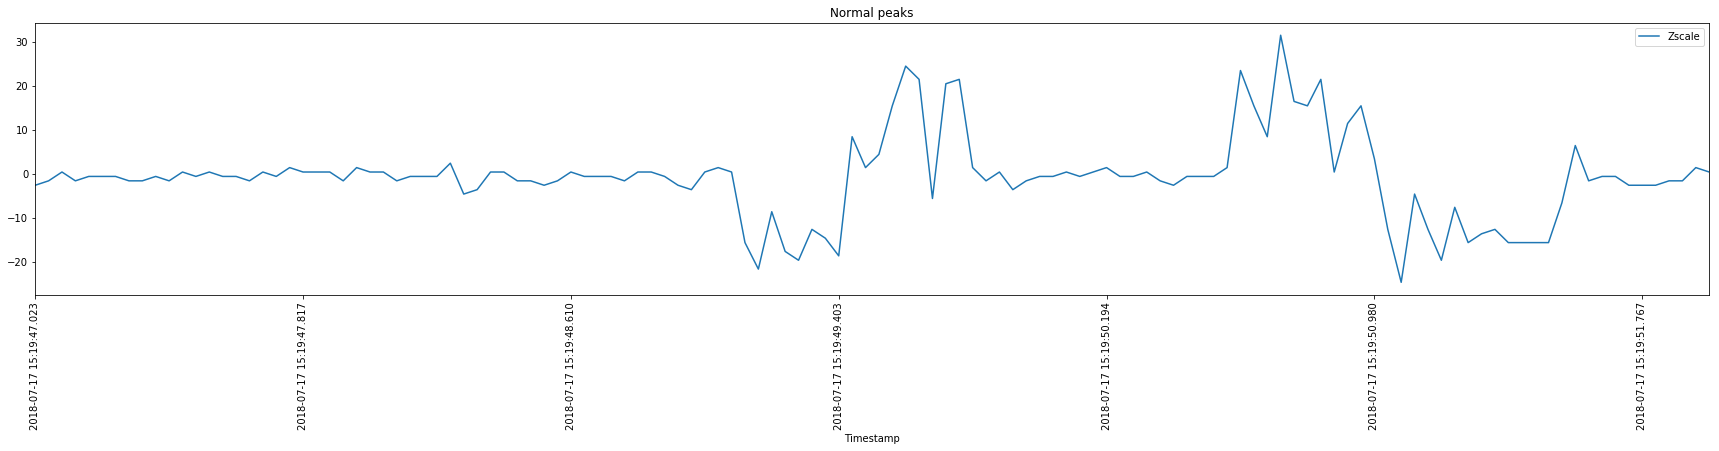

In [56]:
scaledData.createOrReplaceTempView("scaledData")
df_check = spark.sql('''select Timestamp, Timestamp1, Zscale from scaledData where Timestamp1 between '2018-07-17 15:19:47' and '2018-07-17 15:19:51' ''')

# Convert to Pandas and plot
import matplotlib.pyplot as plt
%time temp_pandas = df_check.select("*").toPandas()
temp_pandas.plot(x ='Timestamp', y='Zscale', kind = 'line',rot=90)
plt.title('Normal peaks') 

plt.rcParams["figure.figsize"] = [30, 5]